In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from math import sqrt

In [2]:
pd.options.display.max_columns = None 
pd.options.display.max_rows = None 

In [3]:
def wmape(actual, forecast):
    # we take two series and calculate an output a wmape from it, not to be used in a grouping function

    # make a series called mape
    se_mape = abs(actual-forecast)/actual

    # get a float of the sum of the actual
    ft_actual_sum = actual.sum()

    # get a series of the multiple of the actual & the mape
    se_actual_prod_mape = actual * se_mape

    # summate the prod of the actual and the mape
    ft_actual_prod_mape_sum = se_actual_prod_mape.sum()

    # float: wmape of forecast
    ft_wmape_forecast = ft_actual_prod_mape_sum / ft_actual_sum

    # return a float
    return ft_wmape_forecast

In [4]:
def prepare_data(df):
    x1, x2, x3, x4, x5, x6, target = df['1_week_ago'], df['2_week_ago'], df['3_week_ago'], df['4_week_ago'], df['weeks_since_release'], df['avg_claim_last_month'], df['this_week']
    x1, x2, x3, x4, x5, x6, target = np.array(x1), np.array(x2), np.array(x3), np.array(x4), np.array(x5), np.array(x6), np.array(target)
    x1, x2, x3, x4, x5, x6, target = x1.reshape(-1, 1), x2.reshape(-1, 1), x3.reshape(-1, 1), x4.reshape(-1, 1), x5.reshape(-1, 1), x6.reshape(-1, 1), target.reshape(-1, 1)
    features = np.concatenate((x1, x2, x3, x4, x5, x6), axis = 1)
    
    return features, target

In [5]:
iphone13_df = pd.read_csv('C:/Users/jiax2/Teams/Playground/Modeling_Rio/iPhone13_Final.csv', parse_dates=['weeks_monday','month_year'])
iphone14_df = pd.read_csv('C:/Users/jiax2/Teams/Playground/Modeling_Rio/iPhone14_Final.csv', parse_dates=['weeks_monday','month_year'])
iphone_df = pd.read_csv('C:/Users/jiax2/Teams/Playground/Modeling_Rio/time_series_ML_features_final.csv', parse_dates=['weeks_monday','month_year'])
iphone13 = iphone_df[(iphone_df['phone_model'] == 'apple iphone 13')]
iphone14 = iphone_df[(iphone_df['phone_model'] == 'apple iphone 14')]

In [6]:
iphone13_df.drop(['month_year', 'holiday'], axis=1, inplace=True)
iphone14_df.drop(['month_year', 'holiday'], axis=1, inplace=True)

In [7]:
iphone13 = iphone13[(iphone13['weeks_monday'] >= '2021-11-22')] 
iphone13_beg = iphone13.copy().reset_index()
iphone13_beg = iphone13_beg.head(13)
days_since_iphone14_release = iphone13_beg['days_since_release_date'] + 30
iphone13_beg['days_since_release_date'] = days_since_iphone14_release
iphone13_beg['weeks_since_release'] = days_since_iphone14_release // 7 
iphone13_beg['weeks_monday'] = iphone13_beg['weeks_monday'] - pd.Timedelta(days=8)
iphone13_beg['month'] = iphone13_beg['weeks_monday'].dt.month
iphone13_beg['year'] = iphone13_beg['weeks_monday'].dt.year
iphone13_beg['weeks_since_release'] = iphone13_beg['days_since_release_date'].floordiv(7)
iphone13_beg

,index,phone_model,weeks_monday,month,year,month_year,days_since_release_date,claim,weeks_since_release
0,60,apple iphone 13,2021-11-14,11,2021,2021-11-01,59,3,8
1,64,apple iphone 13,2021-11-21,11,2021,2021-11-01,66,6,9
2,66,apple iphone 13,2021-11-28,11,2021,2021-12-01,73,2,10
3,69,apple iphone 13,2021-12-05,12,2021,2021-12-01,80,10,11
4,76,apple iphone 13,2021-12-12,12,2021,2021-12-01,87,6,12
5,77,apple iphone 13,2021-12-19,12,2021,2021-12-01,94,15,13
6,83,apple iphone 13,2021-12-26,12,2021,2022-01-01,101,7,14
7,85,apple iphone 13,2022-01-02,1,2022,2022-01-01,108,13,15
8,89,apple iphone 13,2022-01-09,1,2022,2022-01-01,115,10,16
9,96,apple iphone 13,2022-01-16,1,2022,2022-01-01,122,11,17


In [8]:
iphone14 = iphone14.copy()
iphone14['weeks_since_release'] = iphone14['days_since_release_date'].floordiv(7)
iphone14

,phone_model,weeks_monday,month,year,month_year,days_since_release_date,claim,weeks_since_release
262,apple iphone 14,2022-11-14,11,2022,2022-11-01,59,9,8
267,apple iphone 14,2022-11-21,11,2022,2022-11-01,66,30,9
271,apple iphone 14,2022-11-28,11,2022,2022-11-01,73,23,10
277,apple iphone 14,2022-12-05,12,2022,2022-12-01,80,43,11
283,apple iphone 14,2022-12-12,12,2022,2022-12-01,87,32,12
289,apple iphone 14,2022-12-19,12,2022,2022-12-01,94,36,13
292,apple iphone 14,2022-12-26,12,2022,2022-12-01,101,44,14
299,apple iphone 14,2023-01-02,1,2023,2023-01-01,108,45,15
303,apple iphone 14,2023-01-09,1,2023,2023-01-01,115,59,16
308,apple iphone 14,2023-01-16,1,2023,2023-01-01,122,60,17


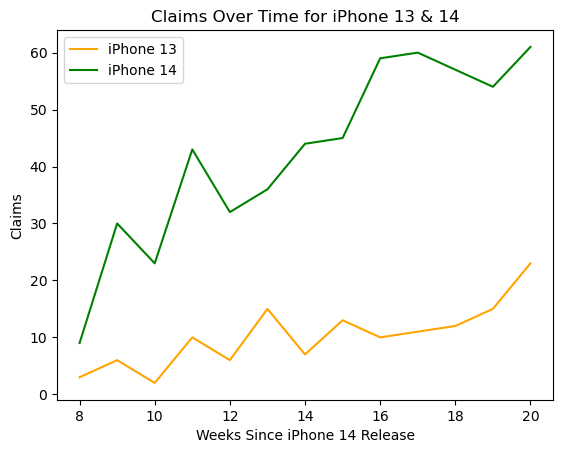

In [9]:
plt.plot(iphone13_beg['weeks_since_release'], iphone13_beg['claim'], color='orange', label='iPhone 13')
plt.plot(iphone14['weeks_since_release'], iphone14['claim'], color='green', label='iPhone 14')

plt.xlabel('Weeks Since iPhone 14 Release')
plt.ylabel('Claims') 
plt.title('Claims Over Time for iPhone 13 & 14')
plt.legend()
plt.show()

In [10]:
iphone13 

,phone_model,weeks_monday,month,year,month_year,days_since_release_date,claim
60,apple iphone 13,2021-11-22,11,2021,2021-11-01,29,3
64,apple iphone 13,2021-11-29,11,2021,2021-11-01,36,6
66,apple iphone 13,2021-12-06,12,2021,2021-12-01,43,2
69,apple iphone 13,2021-12-13,12,2021,2021-12-01,50,10
76,apple iphone 13,2021-12-20,12,2021,2021-12-01,57,6
77,apple iphone 13,2021-12-27,12,2021,2021-12-01,64,15
83,apple iphone 13,2022-01-03,1,2022,2022-01-01,71,7
85,apple iphone 13,2022-01-10,1,2022,2022-01-01,78,13
89,apple iphone 13,2022-01-17,1,2022,2022-01-01,85,10
96,apple iphone 13,2022-01-24,1,2022,2022-01-01,92,11


In [11]:
iphone13 = iphone13[(iphone13['weeks_monday'] >= '2021-11-22')] 
iphone13_all = iphone13.copy().reset_index()
days_since_iphone14_release = iphone13_all['days_since_release_date'] + 30
iphone13_all['days_since_release_date'] = days_since_iphone14_release
iphone13_all['weeks_since_release'] = days_since_iphone14_release // 7 
iphone13_all['weeks_monday'] = iphone13_all['weeks_monday'] - pd.Timedelta(days=8)
iphone13_all['month'] = iphone13_all['weeks_monday'].dt.month
iphone13_all['year'] = iphone13_beg['weeks_monday'].dt.year
iphone13_all['weeks_since_release'] = iphone13_all['days_since_release_date'].floordiv(7)

In [12]:
iphone13_all

,index,phone_model,weeks_monday,month,year,month_year,days_since_release_date,claim,weeks_since_release
0,60,apple iphone 13,2021-11-14,11,2021.0,2021-11-01,59,3,8
1,64,apple iphone 13,2021-11-21,11,2021.0,2021-11-01,66,6,9
2,66,apple iphone 13,2021-11-28,11,2021.0,2021-12-01,73,2,10
3,69,apple iphone 13,2021-12-05,12,2021.0,2021-12-01,80,10,11
4,76,apple iphone 13,2021-12-12,12,2021.0,2021-12-01,87,6,12
5,77,apple iphone 13,2021-12-19,12,2021.0,2021-12-01,94,15,13
6,83,apple iphone 13,2021-12-26,12,2021.0,2022-01-01,101,7,14
7,85,apple iphone 13,2022-01-02,1,2022.0,2022-01-01,108,13,15
8,89,apple iphone 13,2022-01-09,1,2022.0,2022-01-01,115,10,16
9,96,apple iphone 13,2022-01-16,1,2022.0,2022-01-01,122,11,17


In [13]:
iphone13_all = iphone13_all[(iphone13_all['weeks_monday'] <= '2022-05-01')] 

In [14]:
iphone13_all

,index,phone_model,weeks_monday,month,year,month_year,days_since_release_date,claim,weeks_since_release
0,60,apple iphone 13,2021-11-14,11,2021.0,2021-11-01,59,3,8
1,64,apple iphone 13,2021-11-21,11,2021.0,2021-11-01,66,6,9
2,66,apple iphone 13,2021-11-28,11,2021.0,2021-12-01,73,2,10
3,69,apple iphone 13,2021-12-05,12,2021.0,2021-12-01,80,10,11
4,76,apple iphone 13,2021-12-12,12,2021.0,2021-12-01,87,6,12
5,77,apple iphone 13,2021-12-19,12,2021.0,2021-12-01,94,15,13
6,83,apple iphone 13,2021-12-26,12,2021.0,2022-01-01,101,7,14
7,85,apple iphone 13,2022-01-02,1,2022.0,2022-01-01,108,13,15
8,89,apple iphone 13,2022-01-09,1,2022.0,2022-01-01,115,10,16
9,96,apple iphone 13,2022-01-16,1,2022.0,2022-01-01,122,11,17


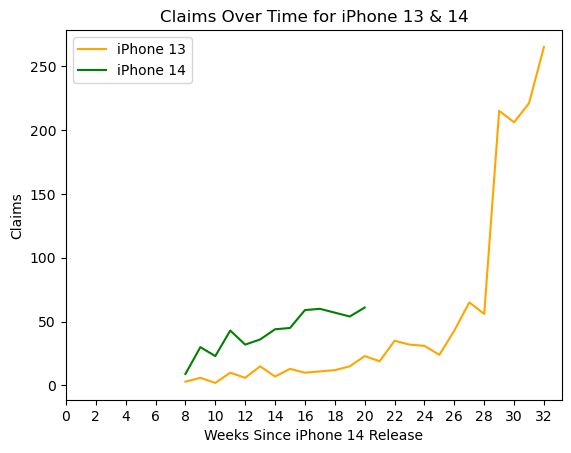

In [15]:
plt.plot(iphone13_all['weeks_since_release'], iphone13_all['claim'], color='orange', label='iPhone 13')
plt.plot(iphone14['weeks_since_release'], iphone14['claim'], color='green', label='iPhone 14')

plt.xlabel('Weeks Since iPhone 14 Release')
plt.ylabel('Claims') 
plt.title('Claims Over Time for iPhone 13 & 14')
plt.legend()
plt.xticks(range(0, max(iphone13_all['weeks_since_release'])+2, 2))
plt.show()

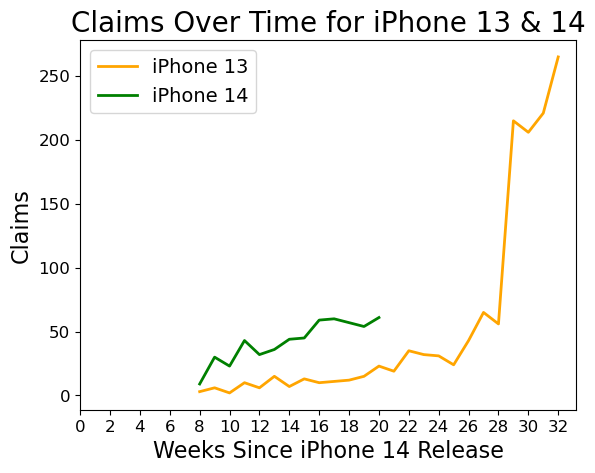

In [16]:
plt.plot(iphone13_all['weeks_since_release'], iphone13_all['claim'], color='orange', linewidth=2, label='iPhone 13')
plt.plot(iphone14['weeks_since_release'], iphone14['claim'], color='green', linewidth=2, label='iPhone 14')

plt.xlabel('Weeks Since iPhone 14 Release', fontsize=16)
plt.ylabel('Claims', fontsize=16) 
plt.title('Claims Over Time for iPhone 13 & 14', fontsize=20)
plt.legend(fontsize=14)
plt.xticks(range(0, max(iphone13_all['weeks_since_release'])+2, 2), fontsize=12)
plt.yticks(fontsize=12)
plt.show()


In [49]:
data = {'weeks_since_release': [20, 21, 22, 23, 24, 25, 26, 27],
        'claim': [79, 75, 91, 88, 100, 93, 112, 134]}

iPhone14_Feb_March_Predictions = pd.DataFrame(data)
iPhone14_Feb_March_Predictions

,weeks_since_release,claim
0,20,79
1,21,75
2,22,91
3,23,88
4,24,100
5,25,93
6,26,112
7,27,134


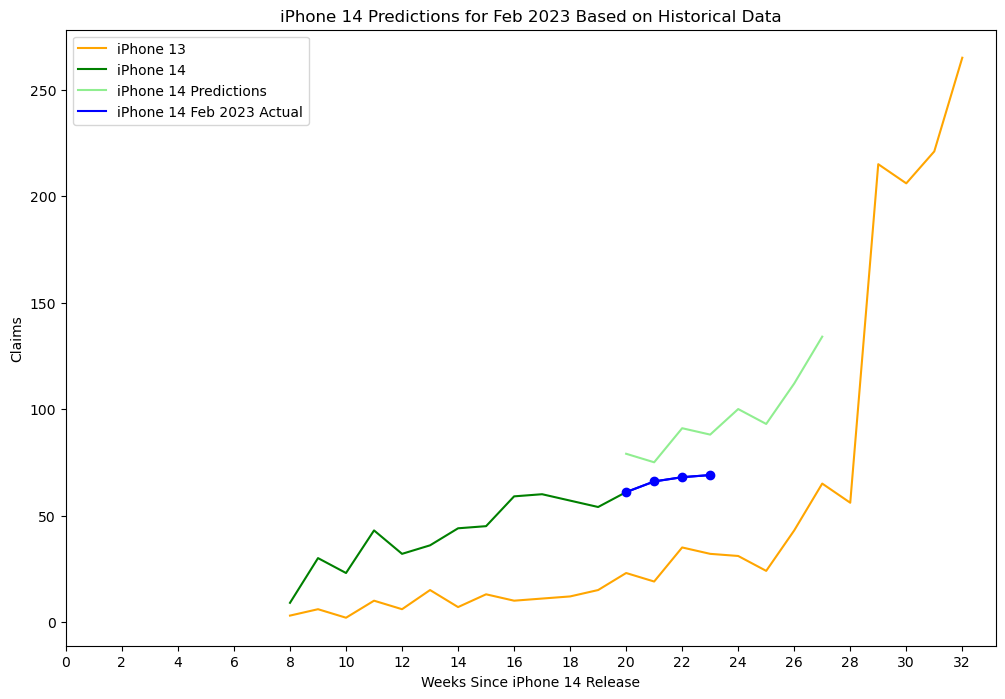

In [51]:
plt.plot(iphone13_all['weeks_since_release'], iphone13_all['claim'], color='orange', label='iPhone 13')
plt.plot(iphone14['weeks_since_release'], iphone14['claim'], color='green', label='iPhone 14')
plt.plot(iPhone14_Feb_March_Predictions['weeks_since_release'], iPhone14_Feb_March_Predictions['claim'], color='lightgreen', label='iPhone 14 Predictions')

plt.plot([20, 21, 22, 23], [61, 66, 68, 69], marker='o', color='blue')
plt.plot([20, 21, 22, 23], [61, 66, 68, 69], color='blue', label='iPhone 14 Feb 2023 Actual')


plt.xlabel('Weeks Since iPhone 14 Release')
plt.ylabel('Claims') 
plt.title('iPhone 14 Predictions for Feb 2023 Based on Historical Data')
plt.legend()
plt.xticks(range(0, max(iphone13_all['weeks_since_release'])+2, 2))
plt.show()

In [19]:
iphone14_avg_claim_per_month = iphone14.groupby('month')['claim'].mean().reset_index()
iphone14_avg_claim_per_month

,month,claim
0,1,55.000000
1,2,61.000000
2,11,20.666667
3,12,38.750000


In [20]:
iphone13_avg_claim_per_month = iphone13_beg.groupby('month')['claim'].mean().reset_index()
iphone13_avg_claim_per_month

,month,claim
0,1,12.200000
1,2,23.000000
2,11,3.666667
3,12,9.500000


In [21]:
merged_df = pd.merge(iphone13_avg_claim_per_month, iphone14_avg_claim_per_month, on='month', suffixes=('_13', '_14'))
merged_df['growth_rate'] = (merged_df['claim_14'] - merged_df['claim_13']) / merged_df['claim_13'] * 100
merged_df['diff'] = merged_df['claim_14'] - merged_df['claim_13']
# drop the second row
merged_df = merged_df.drop(merged_df.index[1])

# move the first row to the last position
first_row = merged_df.iloc[[0]]
merged_df = merged_df.drop(merged_df.index[0])
merged_df = pd.concat([merged_df, first_row])

# print the updated dataframe
merged_df

,month,claim_13,claim_14,growth_rate,diff
2,11,3.666667,20.666667,463.636364,17.00
3,12,9.500000,38.750000,307.894737,29.25
0,1,12.200000,55.000000,350.819672,42.80


In [22]:
new_iphone13 = iphone13_df.iloc[1:].copy()
days_since_iphone14_release = iphone13_df['days_since_release_date'] + 30 
new_iphone13['days_since_release_date'] = days_since_iphone14_release
new_iphone13['weeks_since_release'] = days_since_iphone14_release // 7 
new_iphone13['weeks_monday'] = iphone13_df['weeks_monday'] - pd.Timedelta(days=8)
new_iphone13['month'] = new_iphone13['weeks_monday'].dt.month
new_iphone13['year'] = new_iphone13['weeks_monday'].dt.year
new_iphone13

,days_since_release_date,weeks_monday,month,year,this_week,avg_claim_this_month,avg_claim_last_month,1_week_ago,2_week_ago,3_week_ago,4_week_ago,weeks_since_release
1,87,2021-12-12,12,2021,6,8.25,3.666667,10.0,2.0,6.0,3.0,12
2,94,2021-12-19,12,2021,15,8.25,3.666667,6.0,10.0,2.0,6.0,13
3,101,2021-12-26,12,2021,7,10.60,8.250000,15.0,6.0,10.0,2.0,14
4,108,2022-01-02,1,2022,13,10.60,8.250000,7.0,15.0,6.0,10.0,15
5,115,2022-01-09,1,2022,10,10.60,8.250000,13.0,7.0,15.0,6.0,16
6,122,2022-01-16,1,2022,11,10.60,8.250000,10.0,13.0,7.0,15.0,17
7,129,2022-01-23,1,2022,12,10.60,8.250000,11.0,10.0,13.0,7.0,18
8,136,2022-01-30,1,2022,15,23.00,10.600000,12.0,11.0,10.0,13.0,19
9,143,2022-02-06,2,2022,23,23.00,10.600000,15.0,12.0,11.0,10.0,20
10,150,2022-02-13,2,2022,19,23.00,10.600000,23.0,15.0,12.0,11.0,21


In [23]:
print("iPhone 13 Aligned")
new_iphone13[(new_iphone13['weeks_monday'] >= '2022-02-06') & (new_iphone13['weeks_monday'] <= '2022-03-27')][['weeks_monday', 'weeks_since_release', 'this_week']]

iPhone 13 Aligned


,weeks_monday,weeks_since_release,this_week
9,2022-02-06,20,23
10,2022-02-13,21,19
11,2022-02-20,22,35
12,2022-02-27,23,32
13,2022-03-06,24,31
14,2022-03-13,25,24
15,2022-03-20,26,43
16,2022-03-27,27,65


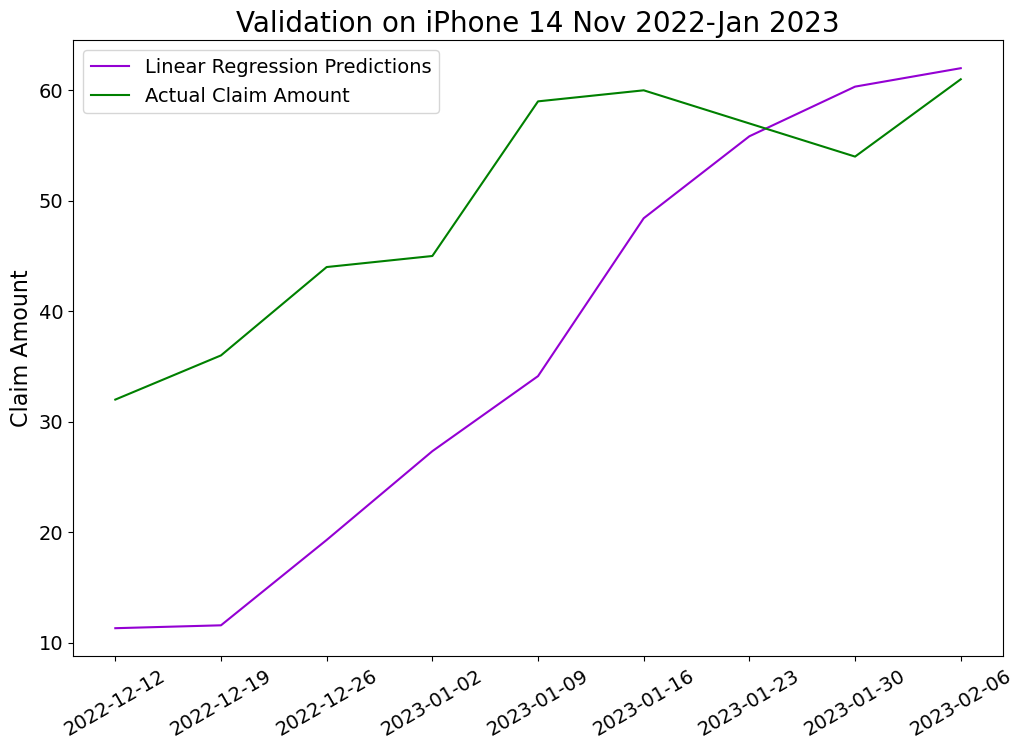

Root Mean sqaured error for Linear Regression model is:  17.459563453845053
WMAPE: 29.57%


In [24]:
iphone13_train = new_iphone13[(new_iphone13['weeks_monday'] <= '2022-11-20')] 
X_train, y_train = prepare_data(iphone13_train)

X_validate, y_validate = prepare_data(iphone14_df)

lin_model = LinearRegression()
lin_model.fit(X_train, y_train)
lin_pred = lin_model.predict(X_validate)
plt.rcParams["figure.figsize"] = (12,8)
plt.plot(lin_pred, label = "Linear Regression Predictions", color = "darkviolet")
plt.plot(y_validate, label = "Actual Claim Amount", color="green")
plt.title("Validation on iPhone 14 Nov 2022-Jan 2023", fontsize=20)
plt.legend(loc="upper left", fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.ylabel("Claim Amount", fontsize=16)
dates = pd.date_range(start="2022-12-12", end="2023-02-06", freq="7D")
date_strings = [date.strftime("%Y-%m-%d") for date in dates]
plt.xticks(range(len(date_strings)), date_strings, rotation=30)

plt.show()
rmse_lr = sqrt(mean_squared_error(lin_pred, y_validate))
print("Root Mean sqaured error for Linear Regression model is: ", rmse_lr)

y_validate_series = pd.Series(y_validate.ravel())
lin_pred_series = pd.Series(lin_pred.ravel())
wmape_score = wmape(y_validate_series, lin_pred_series)
print("WMAPE: {:.2%}".format(wmape_score))

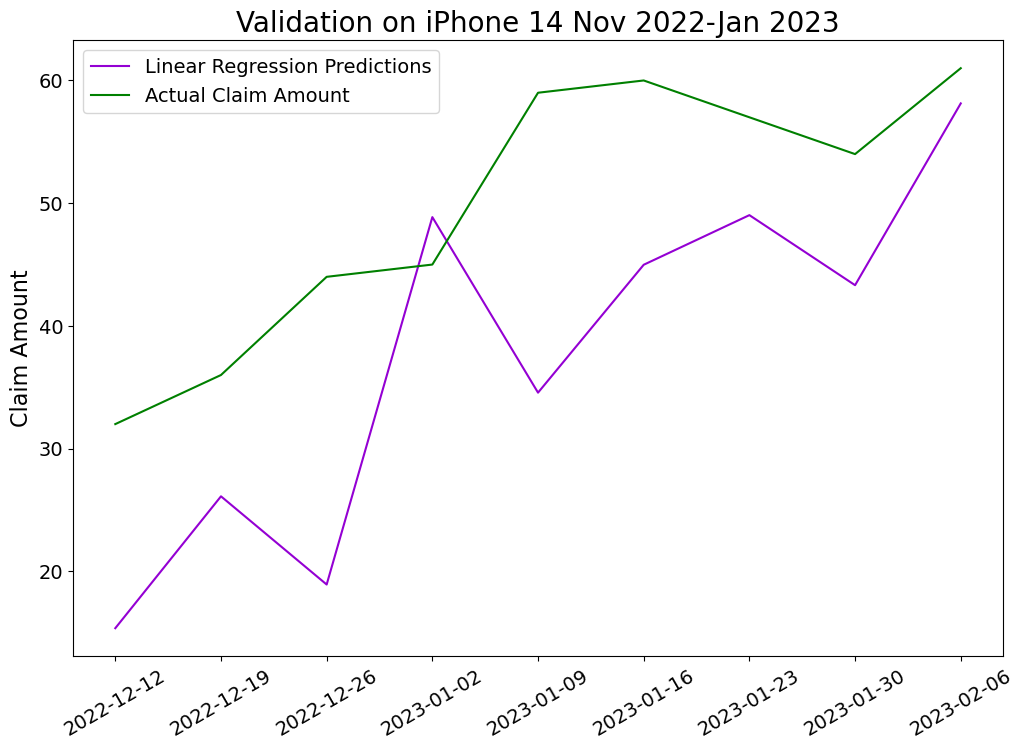

Root Mean sqaured error for Linear Regression model is:  15.004998578831795
WMAPE: 25.99%


In [25]:
iphone13_train = new_iphone13[(new_iphone13['weeks_monday'] <= '2022-03-27')] 
X_train, y_train = prepare_data(iphone13_train)

X_validate, y_validate = prepare_data(iphone14_df)

lin_model = LinearRegression()
lin_model.fit(X_train, y_train)
lin_pred = lin_model.predict(X_validate)
plt.rcParams["figure.figsize"] = (12,8)
plt.plot(lin_pred, label = "Linear Regression Predictions", color = "darkviolet")
plt.plot(y_validate, label = "Actual Claim Amount", color="green")
plt.title("Validation on iPhone 14 Nov 2022-Jan 2023", fontsize=20)
plt.legend(loc="upper left", fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.ylabel("Claim Amount", fontsize=16)
dates = pd.date_range(start="2022-12-12", end="2023-02-06", freq="7D")
date_strings = [date.strftime("%Y-%m-%d") for date in dates]
plt.xticks(range(len(date_strings)), date_strings, rotation=30)

plt.show()
rmse_lr = sqrt(mean_squared_error(lin_pred, y_validate))
print("Root Mean sqaured error for Linear Regression model is: ", rmse_lr)

y_validate_series = pd.Series(y_validate.ravel())
lin_pred_series = pd.Series(lin_pred.ravel())
wmape_score = wmape(y_validate_series, lin_pred_series)
print("WMAPE: {:.2%}".format(wmape_score))

In [26]:
new_rows = [
    {'days_since_release_date': 150, 'weeks_monday': '2023-02-13', 'month': 2, 'year': 2023, 
     'this_week': 66, 'avg_claim_this_month': 66, 'avg_claim_last_month': 55, 
     '1_week_ago': 61, '2_week_ago': 54, '3_week_ago': 57, '4_week_ago': 60, 'weeks_since_release': 21},
    {'days_since_release_date': 157, 'weeks_monday': '2023-02-20', 'month': 2, 'year': 2023, 
     'this_week': 68, 'avg_claim_this_month': 66, 'avg_claim_last_month': 55, 
     '1_week_ago': 66, '2_week_ago': 61, '3_week_ago': 54, '4_week_ago': 57, 'weeks_since_release': 22},
    {'days_since_release_date': 164, 'weeks_monday': '2023-02-27', 'month': 2, 'year': 2023, 
     'this_week': 69, 'avg_claim_this_month': 66, 'avg_claim_last_month': 55, 
     '1_week_ago': 68, '2_week_ago': 66, '3_week_ago': 61, '4_week_ago': 54, 'weeks_since_release': 23}
]

new_rows_df = pd.DataFrame(new_rows)


new_rows_df['weeks_monday'] = pd.to_datetime(new_rows_df['weeks_monday'])


iphone14_df = iphone14_df.append(new_rows_df, ignore_index=True)

iphone14_df['weeks_monday'] = pd.to_datetime(iphone14_df['weeks_monday'])

iphone14_df.loc[8, 'avg_claim_this_month'] = 66
iphone14_df


C:\Users\jiax2\AppData\Local\Temp\ipykernel_7520\1302723654.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  iphone14_df = iphone14_df.append(new_rows_df, ignore_index=True)


,days_since_release_date,weeks_monday,month,year,this_week,avg_claim_this_month,avg_claim_last_month,1_week_ago,2_week_ago,3_week_ago,4_week_ago,weeks_since_release
0,87,2022-12-12,12,2022,32,38.75,20.666667,43.0,23.0,30.0,9.0,12
1,94,2022-12-19,12,2022,36,38.75,20.666667,32.0,43.0,23.0,30.0,13
2,101,2022-12-26,12,2022,44,38.75,20.666667,36.0,32.0,43.0,23.0,14
3,108,2023-01-02,1,2023,45,55.00,38.750000,44.0,36.0,32.0,43.0,15
4,115,2023-01-09,1,2023,59,55.00,38.750000,45.0,44.0,36.0,32.0,16
5,122,2023-01-16,1,2023,60,55.00,38.750000,59.0,45.0,44.0,36.0,17
6,129,2023-01-23,1,2023,57,55.00,38.750000,60.0,59.0,45.0,44.0,18
7,136,2023-01-30,1,2023,54,55.00,38.750000,57.0,60.0,59.0,45.0,19
8,143,2023-02-06,2,2023,61,66.00,55.000000,54.0,57.0,60.0,59.0,20
9,150,2023-02-13,2,2023,66,66.00,55.000000,61.0,54.0,57.0,60.0,21


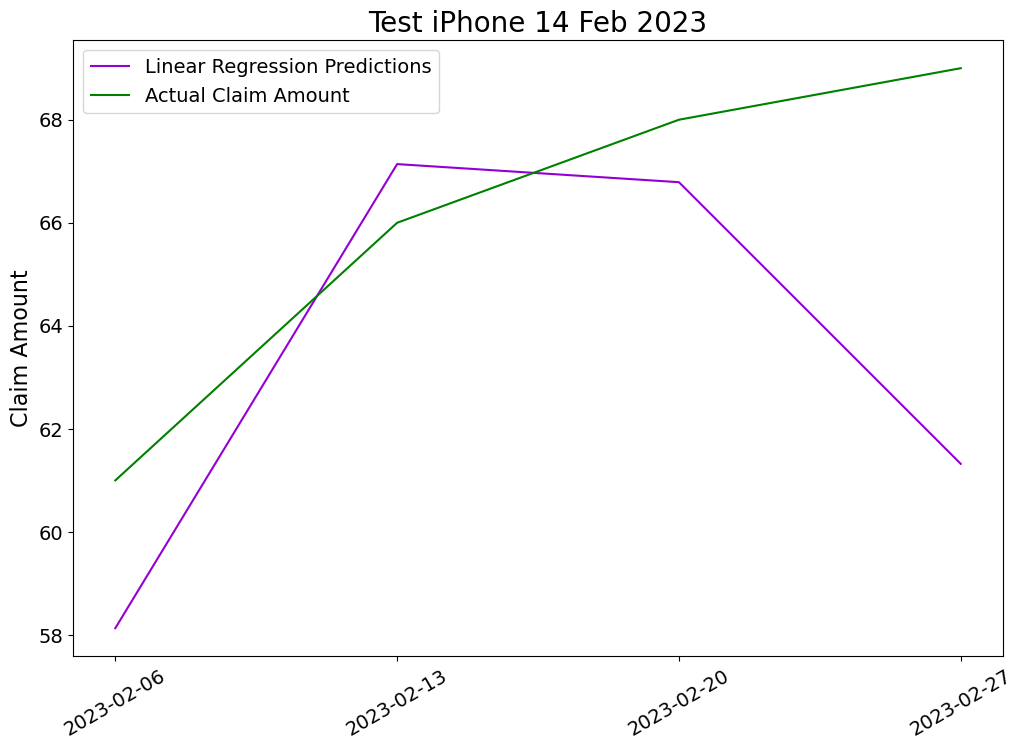

WMAPE: 4.89%


In [27]:
feb2023_iphone14 = iphone14_df.tail(4)

iphone13_train = new_iphone13[(new_iphone13['weeks_monday'] <= '2022-03-27')] 
X_train, y_train = prepare_data(iphone13_train)
X_test, y_test = prepare_data(feb2023_iphone14)


lin_model = LinearRegression()
lin_model.fit(X_train, y_train)
lin_pred = lin_model.predict(X_test)

plt.rcParams["figure.figsize"] = (12,8)
plt.plot(lin_pred, label = "Linear Regression Predictions", color = "darkviolet")
plt.plot(y_test, label = "Actual Claim Amount", color="green")
plt.title("Test iPhone 14 Feb 2023", fontsize=20)
plt.legend(loc="upper left", fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.ylabel("Claim Amount", fontsize=16)
dates = pd.date_range(start="2023-02-06", end="2023-02-27", freq="7D")
date_strings = [date.strftime("%Y-%m-%d") for date in dates]
plt.xticks(range(len(date_strings)), date_strings, rotation=30)
plt.show()

y_test_series = pd.Series(y_test.ravel())
lin_pred_series = pd.Series(lin_pred.ravel())
wmape_score = wmape(y_test_series, lin_pred_series)
print("WMAPE: {:.2%}".format(wmape_score))


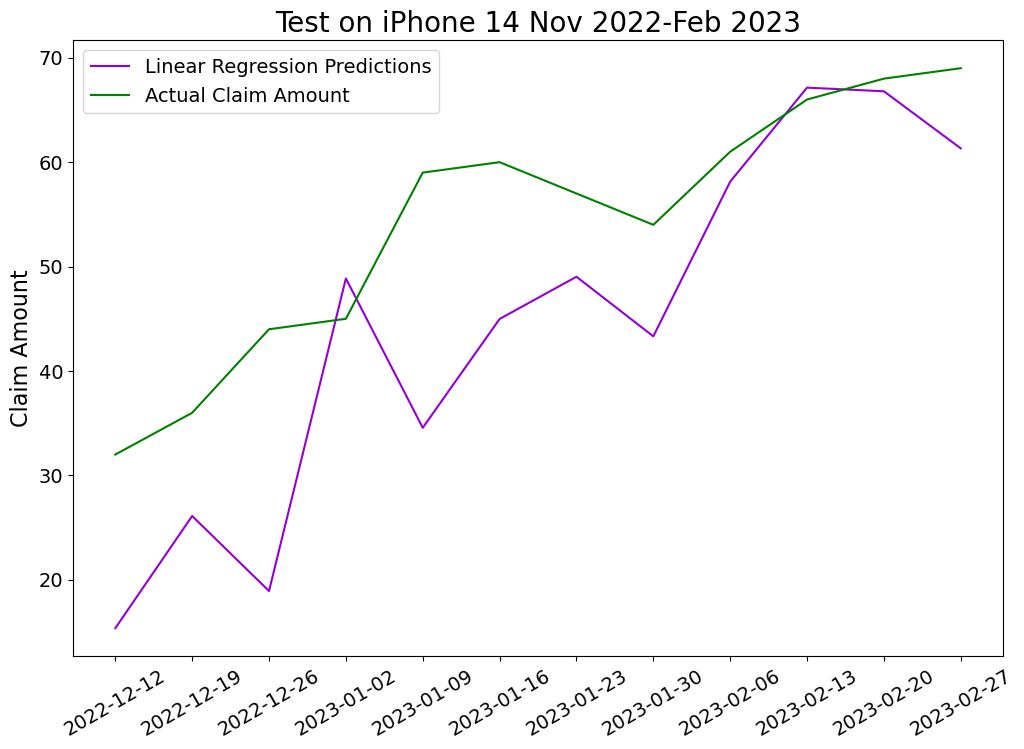

Root Mean sqaured error for Linear Regression model is:  13.191166745608337
WMAPE: 19.43%


In [28]:
X_validate, y_validate = prepare_data(iphone14_df)

lin_model = LinearRegression()
lin_model.fit(X_train, y_train)
lin_pred = lin_model.predict(X_validate)
plt.rcParams["figure.figsize"] = (12,8)
plt.plot(lin_pred, label = "Linear Regression Predictions", color = "darkviolet")
plt.plot(y_validate, label = "Actual Claim Amount", color="green")
plt.title("Test on iPhone 14 Nov 2022-Feb 2023", fontsize=20)
plt.legend(loc="upper left", fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.ylabel("Claim Amount", fontsize=16)
dates = pd.date_range(start="2022-12-12", end="2023-02-27", freq="7D")
date_strings = [date.strftime("%Y-%m-%d") for date in dates]
plt.xticks(range(len(date_strings)), date_strings, rotation=30)

plt.show()
rmse_lr = sqrt(mean_squared_error(lin_pred, y_validate))
print("Root Mean sqaured error for Linear Regression model is: ", rmse_lr)

y_validate_series = pd.Series(y_validate.ravel())
lin_pred_series = pd.Series(lin_pred.ravel())
wmape_score = wmape(y_validate_series, lin_pred_series)
print("WMAPE: {:.2%}".format(wmape_score))

In [29]:
iphone14_df

,days_since_release_date,weeks_monday,month,year,this_week,avg_claim_this_month,avg_claim_last_month,1_week_ago,2_week_ago,3_week_ago,4_week_ago,weeks_since_release
0,87,2022-12-12,12,2022,32,38.75,20.666667,43.0,23.0,30.0,9.0,12
1,94,2022-12-19,12,2022,36,38.75,20.666667,32.0,43.0,23.0,30.0,13
2,101,2022-12-26,12,2022,44,38.75,20.666667,36.0,32.0,43.0,23.0,14
3,108,2023-01-02,1,2023,45,55.00,38.750000,44.0,36.0,32.0,43.0,15
4,115,2023-01-09,1,2023,59,55.00,38.750000,45.0,44.0,36.0,32.0,16
5,122,2023-01-16,1,2023,60,55.00,38.750000,59.0,45.0,44.0,36.0,17
6,129,2023-01-23,1,2023,57,55.00,38.750000,60.0,59.0,45.0,44.0,18
7,136,2023-01-30,1,2023,54,55.00,38.750000,57.0,60.0,59.0,45.0,19
8,143,2023-02-06,2,2023,61,66.00,55.000000,54.0,57.0,60.0,59.0,20
9,150,2023-02-13,2,2023,66,66.00,55.000000,61.0,54.0,57.0,60.0,21


In [30]:
new_iphone13

,days_since_release_date,weeks_monday,month,year,this_week,avg_claim_this_month,avg_claim_last_month,1_week_ago,2_week_ago,3_week_ago,4_week_ago,weeks_since_release
1,87,2021-12-12,12,2021,6,8.25,3.666667,10.0,2.0,6.0,3.0,12
2,94,2021-12-19,12,2021,15,8.25,3.666667,6.0,10.0,2.0,6.0,13
3,101,2021-12-26,12,2021,7,10.60,8.250000,15.0,6.0,10.0,2.0,14
4,108,2022-01-02,1,2022,13,10.60,8.250000,7.0,15.0,6.0,10.0,15
5,115,2022-01-09,1,2022,10,10.60,8.250000,13.0,7.0,15.0,6.0,16
6,122,2022-01-16,1,2022,11,10.60,8.250000,10.0,13.0,7.0,15.0,17
7,129,2022-01-23,1,2022,12,10.60,8.250000,11.0,10.0,13.0,7.0,18
8,136,2022-01-30,1,2022,15,23.00,10.600000,12.0,11.0,10.0,13.0,19
9,143,2022-02-06,2,2022,23,23.00,10.600000,15.0,12.0,11.0,10.0,20
10,150,2022-02-13,2,2022,19,23.00,10.600000,23.0,15.0,12.0,11.0,21


In [31]:
actual = pd.Series([55, 52, 53, 54, 57])
forecast = pd.Series([45, 59, 60, 57, 54])

wmape_score = wmape(actual, forecast)
print("iPhone 14 Jan WMAPE: {:.2%}".format(wmape_score))

iPhone 14 Jan WMAPE: 11.07%


In [32]:
actual = pd.Series([43, 32, 36, 44])
forecast = pd.Series([39, 35, 44, 36])

wmape_score = wmape(actual, forecast)
print("iPhone 14 Dec WMAPE: {:.2%}".format(wmape_score))

iPhone 14 Dec WMAPE: 14.84%


In [33]:
y_validate

array([[32],
       [36],
       [44],
       [45],
       [59],
       [60],
       [57],
       [54],
       [61],
       [66],
       [68],
       [69]], dtype=int64)

In [34]:
lin_pred

array([[15.36947363],
       [26.11518903],
       [18.92844742],
       [48.865264  ],
       [34.56314778],
       [44.98330974],
       [49.02685051],
       [43.31909455],
       [58.13131663],
       [67.13881767],
       [66.78768774],
       [61.3210604 ]])

In [35]:
y_validate - lin_pred

array([[16.63052637],
       [ 9.88481097],
       [25.07155258],
       [-3.865264  ],
       [24.43685222],
       [15.01669026],
       [ 7.97314949],
       [10.68090545],
       [ 2.86868337],
       [-1.13881767],
       [ 1.21231226],
       [ 7.6789396 ]])

In [36]:
iphone14_df

,days_since_release_date,weeks_monday,month,year,this_week,avg_claim_this_month,avg_claim_last_month,1_week_ago,2_week_ago,3_week_ago,4_week_ago,weeks_since_release
0,87,2022-12-12,12,2022,32,38.75,20.666667,43.0,23.0,30.0,9.0,12
1,94,2022-12-19,12,2022,36,38.75,20.666667,32.0,43.0,23.0,30.0,13
2,101,2022-12-26,12,2022,44,38.75,20.666667,36.0,32.0,43.0,23.0,14
3,108,2023-01-02,1,2023,45,55.00,38.750000,44.0,36.0,32.0,43.0,15
4,115,2023-01-09,1,2023,59,55.00,38.750000,45.0,44.0,36.0,32.0,16
5,122,2023-01-16,1,2023,60,55.00,38.750000,59.0,45.0,44.0,36.0,17
6,129,2023-01-23,1,2023,57,55.00,38.750000,60.0,59.0,45.0,44.0,18
7,136,2023-01-30,1,2023,54,55.00,38.750000,57.0,60.0,59.0,45.0,19
8,143,2023-02-06,2,2023,61,66.00,55.000000,54.0,57.0,60.0,59.0,20
9,150,2023-02-13,2,2023,66,66.00,55.000000,61.0,54.0,57.0,60.0,21


In [37]:
iphone14

,phone_model,weeks_monday,month,year,month_year,days_since_release_date,claim,weeks_since_release
262,apple iphone 14,2022-11-14,11,2022,2022-11-01,59,9,8
267,apple iphone 14,2022-11-21,11,2022,2022-11-01,66,30,9
271,apple iphone 14,2022-11-28,11,2022,2022-11-01,73,23,10
277,apple iphone 14,2022-12-05,12,2022,2022-12-01,80,43,11
283,apple iphone 14,2022-12-12,12,2022,2022-12-01,87,32,12
289,apple iphone 14,2022-12-19,12,2022,2022-12-01,94,36,13
292,apple iphone 14,2022-12-26,12,2022,2022-12-01,101,44,14
299,apple iphone 14,2023-01-02,1,2023,2023-01-01,108,45,15
303,apple iphone 14,2023-01-09,1,2023,2023-01-01,115,59,16
308,apple iphone 14,2023-01-16,1,2023,2023-01-01,122,60,17


In [38]:
def predict_next_claim_amount(df, weeks_this_month, growth_init, loss):
    growth_adjustment = growth_init
    
    for i in range(weeks_this_month): 
        x1 = df.iloc[-1]['this_week']
        x2 = df.iloc[-1]['1_week_ago']
        x3 = df.iloc[-1]['2_week_ago']
        x4 = df.iloc[-1]['3_week_ago']
        days = int(df.iloc[-1]['days_since_release_date']) + 7
        x5 = days // 7 
        x6 = df.iloc[-1]['avg_claim_this_month']

        x1, x2, x3, x4, x5, x6 = np.array(x1), np.array(x2), np.array(x3), np.array(x4), np.array(x5), np.array(x6)
        x1, x2, x3, x4, x5, x6 = x1.reshape(-1, 1), x2.reshape(-1, 1), x3.reshape(-1, 1), x4.reshape(-1, 1), x5.reshape(-1, 1), x6.reshape(-1, 1)
        X_next = np.concatenate((x1, x2, x3, x4, x5, x6), axis = 1)
        next_pred = lin_model.predict(X_next).item()
        
        if i > 0:
            growth_adjustment *= (1 - loss)
            
        next_pred += growth_adjustment

        new_row = {
            'this_week': next_pred,
            '1_week_ago': x1.item(),
            '2_week_ago': x2.item(),
            '3_week_ago': x3.item(),
            '4_week_ago': x4.item(),
            'weeks_since_release': x5.item(),
            'days_since_release_date': days, 
            'avg_claim_last_month': x6.item(),
            'avg_claim_this_month': x6.item()
        }

        df = df.append(new_row, ignore_index=True)

    rolling_avg = df['this_week'].rolling(weeks_this_month).mean().iloc[-1]
    df.iloc[-weeks_this_month:, df.columns.get_loc('avg_claim_this_month')] = rolling_avg
    return df
# def predict_next_claim_amount(df, weeks_this_month, growth_adjustment):
#     orig_len = len(df)
#     for i in range(weeks_this_month): 
#         x1 = df.iloc[-1]['this_week']
#         x2 = df.iloc[-1]['1_week_ago']
#         x3 = df.iloc[-1]['2_week_ago']
#         x4 = df.iloc[-1]['3_week_ago']
#         days = int(df.iloc[-1]['days_since_release_date']) + 7
#         x5 = days // 7 
#         x6 = df.iloc[-1]['avg_claim_this_month']

#         x1, x2, x3, x4, x5, x6 = np.array(x1), np.array(x2), np.array(x3), np.array(x4), np.array(x5), np.array(x6)
#         x1, x2, x3, x4, x5, x6 = x1.reshape(-1, 1), x2.reshape(-1, 1), x3.reshape(-1, 1), x4.reshape(-1, 1), x5.reshape(-1, 1), x6.reshape(-1, 1)
#         X_next = np.concatenate((x1, x2, x3, x4, x5, x6), axis = 1)
#         next_pred = lin_model.predict(X_next).item()

#         new_row = {
#             'this_week': next_pred,
#             '1_week_ago': x1.item(),
#             '2_week_ago': x2.item(),
#             '3_week_ago': x3.item(),
#             '4_week_ago': x4.item(),
#             'weeks_since_release': x5.item(),
#             'days_since_release_date': days, 
#             'avg_claim_last_month': x6.item(),
#             'avg_claim_this_month': x6.item()
#         }

#         df = df.append(new_row, ignore_index=True)

#     df.iloc[orig_len:, df.columns.get_loc('this_week')] += growth_adjustment
#     if weeks_this_month >= 1:
#         df.iloc[orig_len + 1:, df.columns.get_loc('1_week_ago')] += growth_adjustment
#     if weeks_this_month >= 3:
#         df.iloc[orig_len + 2:, df.columns.get_loc('2_week_ago')] += growth_adjustment
#     if weeks_this_month >= 4:
#         df.iloc[orig_len + 3:, df.columns.get_loc('3_week_ago')] += growth_adjustment
#     if weeks_this_month >= 5:
#         df.iloc[orig_len + 4:, df.columns.get_loc('4_week_ago')] += growth_adjustment
#     rolling_avg = df['this_week'].rolling(weeks_this_month).mean().iloc[-1]
#     df.iloc[-weeks_this_month:, df.columns.get_loc('avg_claim_this_month')] = rolling_avg

#     return df

My Predictions:
[69.865264   71.09571657 63.59964225 57.39242081 83.79869636]
Actual:
[45 59 60 57 54]


My Prediction Avg claim this month:69.1503479988288
Actual Avg claim this month: 55.0


C:\Users\jiax2\AppData\Local\Temp\ipykernel_7520\4185024394.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True)
C:\Users\jiax2\AppData\Local\Temp\ipykernel_7520\4185024394.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True)
C:\Users\jiax2\AppData\Local\Temp\ipykernel_7520\4185024394.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True)
C:\Users\jiax2\AppData\Local\Temp\ipykernel_7520\4185024394.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True)
C:\Users\jiax2\AppDa

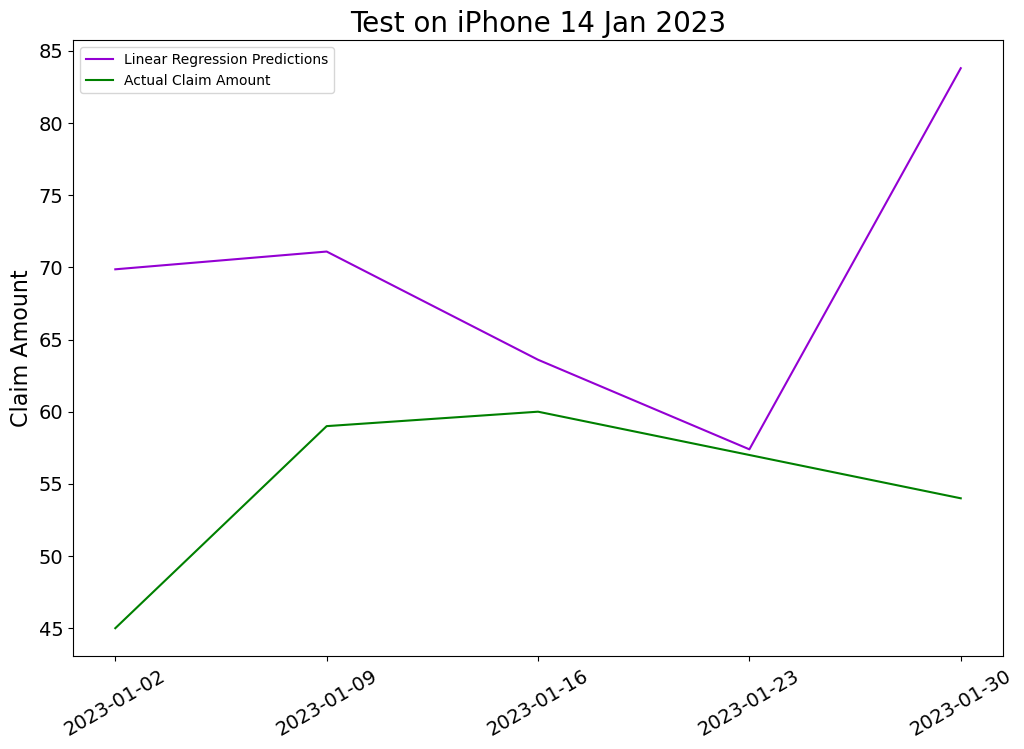

Root Mean sqaured error for Linear Regression model is:  18.25191188026576
WMAPE: 25.73%


In [39]:
weeks_in_Jan23 = 5
iPhone14_predict_Jan23 = iphone14_df.iloc[:3].copy()
iPhone14_predict_Jan23 = predict_next_claim_amount(iPhone14_predict_Jan23, weeks_in_Jan23, 21, 0)

my_pred = iPhone14_predict_Jan23['this_week'].tail(weeks_in_Jan23).to_numpy()
print("My Predictions:")
print(my_pred)

truth = np.array(iphone14_df.iloc[3:8]['this_week'].values)
print("Actual:")
print(truth)

print("\n")

my_pred_avg_claim_this_month = iPhone14_predict_Jan23.iloc[-1]['avg_claim_this_month']
print("My Prediction Avg claim this month:" + str(my_pred_avg_claim_this_month))

actual_avg_claim_this_month = iphone14_df.iloc[3]['avg_claim_this_month']
print("Actual Avg claim this month: " + str(actual_avg_claim_this_month))

plt.rcParams["figure.figsize"] = (12,8)
plt.plot(my_pred, label = "Linear Regression Predictions", color = "darkviolet")
plt.plot(truth, label = "Actual Claim Amount", color = "green")
plt.title("Test on iPhone 14 Jan 2023", fontsize=20)
plt.legend(loc="upper left")
plt.ylabel("Claim Amount", fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=14)
dates = pd.date_range(start="2023-01-02", end="2023-01-30", freq="7D")
date_strings = [date.strftime("%Y-%m-%d") for date in dates]
plt.xticks(range(len(date_strings)), date_strings, rotation=30)

plt.show()
rmse_lr = sqrt(mean_squared_error(my_pred, truth))
print("Root Mean sqaured error for Linear Regression model is: ", rmse_lr)

truth_series = pd.Series(truth.ravel())
my_pred_series = pd.Series(my_pred.ravel())
wmape_score = wmape(truth_series, my_pred_series)
print("WMAPE: {:.2%}".format(wmape_score))


In [40]:
weeks_in_Feb23 = 4
iPhone14_predict_Feb23 = iphone14_df.iloc[:-1].copy()
iPhone14_predict_Feb23 = predict_next_claim_amount(iPhone14_predict_Feb23, weeks_in_Feb23, 0, 0)

my_pred = iPhone14_predict_Feb23['this_week'].tail(weeks_in_Feb23).to_numpy()
print("My February 2023 Predictions for iPhone14:")
print(my_pred)


print("\n")
 
my_pred_avg_claim_this_month = iPhone14_predict_Feb23.iloc[-1]['avg_claim_this_month']
print("My Prediction Avg claim February 2023:" + str(my_pred_avg_claim_this_month))


iPhone14_predict_Feb23


My February 2023 Predictions for iPhone14:
[61.52681282 63.05451932 72.12347093 83.04499268]


My Prediction Avg claim February 2023:69.93744893879136


C:\Users\jiax2\AppData\Local\Temp\ipykernel_7520\4185024394.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True)
C:\Users\jiax2\AppData\Local\Temp\ipykernel_7520\4185024394.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True)
C:\Users\jiax2\AppData\Local\Temp\ipykernel_7520\4185024394.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True)
C:\Users\jiax2\AppData\Local\Temp\ipykernel_7520\4185024394.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True)


,days_since_release_date,weeks_monday,month,year,this_week,avg_claim_this_month,avg_claim_last_month,1_week_ago,2_week_ago,3_week_ago,4_week_ago,weeks_since_release
0,87.0,2022-12-12,12.0,2022.0,32.000000,38.750000,20.666667,43.000000,23.000000,30.000000,9.0,12.0
1,94.0,2022-12-19,12.0,2022.0,36.000000,38.750000,20.666667,32.000000,43.000000,23.000000,30.0,13.0
2,101.0,2022-12-26,12.0,2022.0,44.000000,38.750000,20.666667,36.000000,32.000000,43.000000,23.0,14.0
3,108.0,2023-01-02,1.0,2023.0,45.000000,55.000000,38.750000,44.000000,36.000000,32.000000,43.0,15.0
4,115.0,2023-01-09,1.0,2023.0,59.000000,55.000000,38.750000,45.000000,44.000000,36.000000,32.0,16.0
5,122.0,2023-01-16,1.0,2023.0,60.000000,55.000000,38.750000,59.000000,45.000000,44.000000,36.0,17.0
6,129.0,2023-01-23,1.0,2023.0,57.000000,55.000000,38.750000,60.000000,59.000000,45.000000,44.0,18.0
7,136.0,2023-01-30,1.0,2023.0,54.000000,55.000000,38.750000,57.000000,60.000000,59.000000,45.0,19.0
8,143.0,2023-02-06,2.0,2023.0,61.000000,66.000000,55.000000,54.000000,57.000000,60.000000,59.0,20.0
9,150.0,2023-02-13,2.0,2023.0,66.000000,66.000000,55.000000,61.000000,54.000000,57.000000,60.0,21.0


In [41]:
iphone14_df

,days_since_release_date,weeks_monday,month,year,this_week,avg_claim_this_month,avg_claim_last_month,1_week_ago,2_week_ago,3_week_ago,4_week_ago,weeks_since_release
0,87,2022-12-12,12,2022,32,38.75,20.666667,43.0,23.0,30.0,9.0,12
1,94,2022-12-19,12,2022,36,38.75,20.666667,32.0,43.0,23.0,30.0,13
2,101,2022-12-26,12,2022,44,38.75,20.666667,36.0,32.0,43.0,23.0,14
3,108,2023-01-02,1,2023,45,55.00,38.750000,44.0,36.0,32.0,43.0,15
4,115,2023-01-09,1,2023,59,55.00,38.750000,45.0,44.0,36.0,32.0,16
5,122,2023-01-16,1,2023,60,55.00,38.750000,59.0,45.0,44.0,36.0,17
6,129,2023-01-23,1,2023,57,55.00,38.750000,60.0,59.0,45.0,44.0,18
7,136,2023-01-30,1,2023,54,55.00,38.750000,57.0,60.0,59.0,45.0,19
8,143,2023-02-06,2,2023,61,66.00,55.000000,54.0,57.0,60.0,59.0,20
9,150,2023-02-13,2,2023,66,66.00,55.000000,61.0,54.0,57.0,60.0,21


In [42]:
iphone14_df

,days_since_release_date,weeks_monday,month,year,this_week,avg_claim_this_month,avg_claim_last_month,1_week_ago,2_week_ago,3_week_ago,4_week_ago,weeks_since_release
0,87,2022-12-12,12,2022,32,38.75,20.666667,43.0,23.0,30.0,9.0,12
1,94,2022-12-19,12,2022,36,38.75,20.666667,32.0,43.0,23.0,30.0,13
2,101,2022-12-26,12,2022,44,38.75,20.666667,36.0,32.0,43.0,23.0,14
3,108,2023-01-02,1,2023,45,55.00,38.750000,44.0,36.0,32.0,43.0,15
4,115,2023-01-09,1,2023,59,55.00,38.750000,45.0,44.0,36.0,32.0,16
5,122,2023-01-16,1,2023,60,55.00,38.750000,59.0,45.0,44.0,36.0,17
6,129,2023-01-23,1,2023,57,55.00,38.750000,60.0,59.0,45.0,44.0,18
7,136,2023-01-30,1,2023,54,55.00,38.750000,57.0,60.0,59.0,45.0,19
8,143,2023-02-06,2,2023,61,66.00,55.000000,54.0,57.0,60.0,59.0,20
9,150,2023-02-13,2,2023,66,66.00,55.000000,61.0,54.0,57.0,60.0,21


In [43]:
new_iphone13

,days_since_release_date,weeks_monday,month,year,this_week,avg_claim_this_month,avg_claim_last_month,1_week_ago,2_week_ago,3_week_ago,4_week_ago,weeks_since_release
1,87,2021-12-12,12,2021,6,8.25,3.666667,10.0,2.0,6.0,3.0,12
2,94,2021-12-19,12,2021,15,8.25,3.666667,6.0,10.0,2.0,6.0,13
3,101,2021-12-26,12,2021,7,10.60,8.250000,15.0,6.0,10.0,2.0,14
4,108,2022-01-02,1,2022,13,10.60,8.250000,7.0,15.0,6.0,10.0,15
5,115,2022-01-09,1,2022,10,10.60,8.250000,13.0,7.0,15.0,6.0,16
6,122,2022-01-16,1,2022,11,10.60,8.250000,10.0,13.0,7.0,15.0,17
7,129,2022-01-23,1,2022,12,10.60,8.250000,11.0,10.0,13.0,7.0,18
8,136,2022-01-30,1,2022,15,23.00,10.600000,12.0,11.0,10.0,13.0,19
9,143,2022-02-06,2,2022,23,23.00,10.600000,15.0,12.0,11.0,10.0,20
10,150,2022-02-13,2,2022,19,23.00,10.600000,23.0,15.0,12.0,11.0,21


In [44]:
x1 = 43
x2 = 23
x3 = 30
x4 = 9
x5 = 12
x6 = 20.67
x1, x2, x3, x4, x5, x6 = np.array(x1), np.array(x2), np.array(x3), np.array(x4), np.array(x5), np.array(x6)
x1, x2, x3, x4, x5, x6 = x1.reshape(-1, 1), x2.reshape(-1, 1), x3.reshape(-1, 1), x4.reshape(-1, 1), x5.reshape(-1, 1), x6.reshape(-1, 1)
X_next = np.concatenate((x1, x2, x3, x4, x5, x6), axis = 1)
Dec_12_22_pred = lin_model.predict(X_next)
Dec_12_22_pred += 30

# x1 = Dec_12_22_pred
# x2 = 43
# x3 = 23
# x4 = 30
# x5 = 13 
# x6 = 20.67
# x1, x2, x3, x4, x5, x6 = np.array(x1), np.array(x2), np.array(x3), np.array(x4), np.array(x5), np.array(x6)
# x1, x2, x3, x4, x5, x6 = x1.reshape(-1, 1), x2.reshape(-1, 1), x3.reshape(-1, 1), x4.reshape(-1, 1), x5.reshape(-1, 1), x6.reshape(-1, 1)
# X_next = np.concatenate((x1, x2, x3, x4, x5, x6), axis = 1)
# Dec_19_22_pred = lin_model.predict(X_next)
# Dec_19_22_pred 


iPhone14_predict_Dec23 = pd.DataFrame(columns=iphone14_df.columns)

new_row = {
            'this_week': Dec_12_22_pred.item(),
            '1_week_ago': x1.item(),
            '2_week_ago': x2.item(),
            '3_week_ago': x3.item(),
            '4_week_ago': x4.item(),
            'days_since_release_date': 87,
            'weeks_since_release': x5.item(),
            'avg_claim_last_month': x6.item(),
            'avg_claim_this_month': x6.item()
        }
iPhone14_predict_Dec23 = iPhone14_predict_Dec23.append(new_row, ignore_index=True)

iPhone14_predict_Dec23 = predict_next_claim_amount(iPhone14_predict_Dec23, 2, 27, 0.1)
iPhone14_predict_Dec23
# my_pred = iPhone14_predict_Dec23['this_week'].tail(weeks_in_Jan23).to_numpy()
# print("My Predictions:")
# print(my_pred)

# truth = np.array(iphone14_df.iloc[3:8]['this_week'].values)
# print("Actual:")
# print(truth)

# print("\n")

# my_pred_avg_claim_this_month = iPhone14_predict_Jan23.iloc[-1]['avg_claim_this_month']
# print("My Prediction Avg claim this month:" + str(my_pred_avg_claim_this_month))

# actual_avg_claim_this_month = iphone14_df.iloc[3]['avg_claim_this_month']
# print("Actual Avg claim this month: " + str(actual_avg_claim_this_month))

# plt.rcParams["figure.figsize"] = (12,8)
# plt.plot(my_pred, label = "Linear Regression Predictions")
# plt.plot(truth, label = "Actual Claim Amount")
# plt.title("Test on iPhone 14 Jan 2023")
# plt.legend(loc="upper left")
# plt.show()
# rmse_lr = sqrt(mean_squared_error(my_pred, truth))
# print("Root Mean sqaured error for Linear Regression model is: ", rmse_lr)

# truth_series = pd.Series(truth.ravel())
# my_pred_series = pd.Series(my_pred.ravel())
# wmape_score = wmape(truth_series, my_pred_series)
# print("WMAPE: {:.2%}".format(wmape_score))

C:\Users\jiax2\AppData\Local\Temp\ipykernel_7520\1177851563.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  iPhone14_predict_Dec23 = iPhone14_predict_Dec23.append(new_row, ignore_index=True)
C:\Users\jiax2\AppData\Local\Temp\ipykernel_7520\4185024394.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True)
C:\Users\jiax2\AppData\Local\Temp\ipykernel_7520\4185024394.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True)


,days_since_release_date,weeks_monday,month,year,this_week,avg_claim_this_month,avg_claim_last_month,1_week_ago,2_week_ago,3_week_ago,4_week_ago,weeks_since_release
0,87.0,NaN,NaN,NaN,45.369536,20.670000,20.67,43.000000,23.000000,30.0,9.0,12.0
1,94.0,NaN,NaN,NaN,61.466791,57.629684,20.67,45.369536,43.000000,23.0,30.0,13.0
2,101.0,NaN,NaN,NaN,53.792576,57.629684,20.67,61.466791,45.369536,43.0,23.0,14.0


In [45]:
iphone14_df

,days_since_release_date,weeks_monday,month,year,this_week,avg_claim_this_month,avg_claim_last_month,1_week_ago,2_week_ago,3_week_ago,4_week_ago,weeks_since_release
0,87,2022-12-12,12,2022,32,38.75,20.666667,43.0,23.0,30.0,9.0,12
1,94,2022-12-19,12,2022,36,38.75,20.666667,32.0,43.0,23.0,30.0,13
2,101,2022-12-26,12,2022,44,38.75,20.666667,36.0,32.0,43.0,23.0,14
3,108,2023-01-02,1,2023,45,55.00,38.750000,44.0,36.0,32.0,43.0,15
4,115,2023-01-09,1,2023,59,55.00,38.750000,45.0,44.0,36.0,32.0,16
5,122,2023-01-16,1,2023,60,55.00,38.750000,59.0,45.0,44.0,36.0,17
6,129,2023-01-23,1,2023,57,55.00,38.750000,60.0,59.0,45.0,44.0,18
7,136,2023-01-30,1,2023,54,55.00,38.750000,57.0,60.0,59.0,45.0,19
8,143,2023-02-06,2,2023,61,66.00,55.000000,54.0,57.0,60.0,59.0,20
9,150,2023-02-13,2,2023,66,66.00,55.000000,61.0,54.0,57.0,60.0,21
